Everything that has been done here comes from:
http://nbviewer.jupyter.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb
    
Many things have been dropped as the main idea here was to manipulate the codes and the graphics part.
Please refer to the real tutorial to have a clear of what is done

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
#from KaggleAux import predict as ka # see github.com/agconti/kaggleaux for more details

Import data into the workspace :

In [2]:
from azureml import Workspace
ws = Workspace(
    workspace_id='9a7ccc9931e44138ae82e586a9e1a968',
    authorization_token='H2i63DLOJUeGzGLMtZPU+qTBL5myo6JuBFbDgMkiuSTdRhZoxIsr7BWjHoohH4VpScIhZqlRpPpqaqRdZfvzkQ==',
    endpoint='https://studioapi.azureml.net'
)
ds = ws.datasets['train.csv']
df = ds.to_dataframe()

Let's take a look on the available data:

In [ ]:
df

We will tak e look only on those who have a ticket and a cabin :

In [3]:
df = df.drop(['Ticket','Cabin'], axis=1)
# Remove NaN values
df = df.dropna() 

To visualize the dataset :

In [ ]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)")    

plt.subplot2grid((2,3),(0,1))
plt.scatter(df.Survived, df.Age, alpha=alpha_scatterplot)
# sets the y axis lable
plt.ylabel("Age")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
df.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
plt.title("Class Distribution")

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
df.Age[df.Pclass == 1].plot(kind='kde')    
df.Age[df.Pclass == 2].plot(kind='kde')
df.Age[df.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
df.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(df.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")

The main idea is to fin who died and who lived. We can first check on the sex ration :

In [ ]:
fig = plt.figure(figsize=(18,6))

#create a plot of two subsets, male and female, of the survived variable.
#After we do that we call value_counts() so it can be easily plotted as a bar graph. 
#'barh' is just a horizontal bar graph
df_male = df.Survived[df.Sex == 'male'].value_counts().sort_index()
df_female = df.Survived[df.Sex == 'female'].value_counts().sort_index()

ax1 = fig.add_subplot(121)
df_male.plot(kind='barh',label='Male', alpha=0.55)
df_female.plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived? with respect to Gender, (raw value counts) "); plt.legend(loc='best')
ax1.set_ylim(-1, 2) 

#adjust graph to display the proportions of survival by gender
ax2 = fig.add_subplot(122)
(df_male/float(df_male.sum())).plot(kind='barh',label='Male', alpha=0.55)  
(df_female/float(df_female.sum())).plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived proportionally? with respect to Gender"); plt.legend(loc='best')

ax2.set_ylim(-1, 2)

In [ ]:
fig = plt.figure(figsize=(18,4), dpi=1600)
alpha_level = 0.65

# building on the previous code, here we create an additional subset with in the gender subset 
# we created for the survived variable. I know, thats a lot of subsets. After we do that we call 
# value_counts() so it it can be easily plotted as a bar graph. this is repeated for each gender 
# class pair.
ax1=fig.add_subplot(141)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female, highclass', color='#FA2479', alpha=alpha_level)
ax1.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=alpha_level)
ax2.set_xticklabels(["Died","Survived"], rotation=0)
ax2.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=alpha_level)
ax3.set_xticklabels(["Died","Survived"], rotation=0)
ax3.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male, highclass', alpha=alpha_level, color='steelblue')
ax4.set_xticklabels(["Died","Survived"], rotation=0)
ax4.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

We can see that almost no female from high class survived, but on low class it was almost one chance on two.

create an environment fo test

In [6]:
# model formula
# here the ~ sign is an = sign, and the features of our dataset
# are written as a formula to predict survived. The C() lets our 
# regression know that those variables are categorical.
# Ref: http://patsy.readthedocs.org/en/latest/formulas.html
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp  + C(Embarked)' 
# create a results dictionary to hold our regression results for easy analysis later        
results = {} 

In [7]:
# create a regression friendly dataframe using patsy's dmatrices function
y,x = dmatrices(formula, data=df, return_type='dataframe')

# instantiate our model
model = sm.Logit(y,x)

# fit our model to the training data
res = model.fit()

# save the result for outputing predictions later
results['Logit'] = [res, formula]
res.summary()

Optimization terminated successfully.
         Current function value: 0.444388
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Thu, 16 Mar 2017   Pseudo R-squ.:                  0.3414
Time:                        14:24:12   Log-Likelihood:                -316.40
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 5.992e-67
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            4.5423      0.474      9.583      0.000         3.613     5.471
C(Pclass)[T.2]      -1.2673      0.299     -4.245      0.000        -1.852    -0.682
C(Pclass)[T.3]      -2.4966      0.296     -8.422      0.000        -3.078    -1.916
C(Sex)[T.male]      -2.6239      0.218    -12.060      0.000        -3.050    -2.197
C(Embarked)[T.Q]    -0.8351      0.597     -1.398      0.162        -2.006     0.335
C(Embarked)[T.S]    -0.4254      0.271     -1.572      0.116        -0.956     0.105
Age                 -0.0436      0.008     -5.264      0.000        -0.060    -0.027
SibSp               -0.3697      0.123     -3.004      0.003        -0.611    -0.129
====================================================================================
"""

In [ ]:
# Plot Predictions Vs Actual
plt.figure(figsize=(18,4));
plt.subplot(121, axisbg="#DBDBDB")
# generate predictions from our fitted model
ypred = res.predict(x)
plt.plot(x.index, ypred, 'bo', x.index, y, 'mo', alpha=.25);
plt.grid(color='white', linestyle='dashed')
plt.title('Logit predictions, Blue: \nFitted/predicted values: Red');

# Residuals
ax2 = plt.subplot(122, axisbg="#DBDBDB")
plt.plot(res.resid_dev, 'r-')
plt.grid(color='white', linestyle='dashed')
ax2.set_xlim(-1, len(res.resid_dev))
plt.title('Logit Residuals');

In [ ]:
fig = plt.figure(figsize=(18,9), dpi=1600)
a = .2

# Below are examples of more advanced plotting. 
# It it looks strange check out the tutorial above.
fig.add_subplot(221, axisbg="#DBDBDB")
kde_res = KDEUnivariate(res.predict())
kde_res.fit()
plt.plot(kde_res.support,kde_res.density)
plt.fill_between(kde_res.support,kde_res.density, alpha=a)
plt.title("Distribution of our Predictions")

fig.add_subplot(222, axisbg="#DBDBDB")
plt.scatter(res.predict(),x['C(Sex)[T.male]'] , alpha=a)
plt.grid(b=True, which='major', axis='x')
plt.xlabel("Predicted chance of survival")
plt.ylabel("Gender Bool")
plt.title("The Change of Survival Probability by Gender (1 = Male)")

fig.add_subplot(223, axisbg="#DBDBDB")
plt.scatter(res.predict(),x['C(Pclass)[T.3]'] , alpha=a)
plt.xlabel("Predicted chance of survival")
plt.ylabel("Class Bool")
plt.grid(b=True, which='major', axis='x')
plt.title("The Change of Survival Probability by Lower Class (1 = 3rd Class)")

fig.add_subplot(224, axisbg="#DBDBDB")
plt.scatter(res.predict(),x.Age , alpha=a)
plt.grid(True, linewidth=0.15)
plt.title("The Change of Survival Probability by Age")
plt.xlabel("Predicted chance of survival")
plt.ylabel("Age")

In [8]:
from azureml import Workspace
ws = Workspace(
    workspace_id='9a7ccc9931e44138ae82e586a9e1a968',
    authorization_token='H2i63DLOJUeGzGLMtZPU+qTBL5myo6JuBFbDgMkiuSTdRhZoxIsr7BWjHoohH4VpScIhZqlRpPpqaqRdZfvzkQ==',
    endpoint='https://studioapi.azureml.net'
)
ds = ws.datasets['test.csv']
test_data= ds.to_dataframe()

In [9]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [10]:
test_data['Survived'] = 1.23

In [11]:

def get_dataframe_intersection(df, comparator1, comparator2):
    """
    Return a dataframe with only the columns found in a comparative dataframe.

    Parameters
    ----------
    comparator1: DataFrame
        DataFrame to preform comparison on.
    comparator2: DataFrame
        DataFrame to compare with.

    Returns
    -------
    DataFrame:
        Data frame with columns not found in comparator dropped.

    """
    to_drop = list((c for c in comparator1 if c not in comparator2))
    return df.drop(to_drop, axis=1)


def get_dataframes_intersections(df1, comparator1, df2, comparator2):
    """
    Return DataFrames with the intersection of their column values.

    Parameters
    ----------
    comparator1: DataFrame
        DataFrame to preform comparison on.
    comparator2: DataFrame
        DataFrame to compare with.

    Returns
    -------
    Tuple:
        The resultingDataframe with columns not found in comparator dropped.

    """
    comparator1 = get_dataframe_intersection(df1, comparator1, comparator2)
    comparator2 = get_dataframe_intersection(df2, comparator2, comparator1)
    return comparator1, comparator2


def predict(test_data, results, model_name):
    """
    Return predictions of based on model resutls.

    Parameters
    ----------
    test_data: DataFrame
        should be test data you are trying to predict
    results: dict
        should be dict of your models results wrapper and the formula used
        to produce it.
            ie.
            results['Model_Name'] = {
            [<statsmodels.regression.linear_model.RegressionResultsWrapper> , 
            "Price ~ I(Supply, Demand)]
            }
    model_name: str
        should be the name of your model. You can iterate through the results dict.

    Returns
    -------
    NumPy array
        Predictions in a flat NumPy array.

    Example
    -------
    results = {'Logit': [<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x117896650>,
               'survived ~ C(pclass) + C(sex) + age + sibsp  + C(embarked)']}
    compared_resuts = predict(test_data, results, 'Logit')

    """
    model_params = DataFrame(results[model_name][0].params)
    formula = results[model_name][1]

    # Create regression friendly test DataFrame
    yt, xt = dmatrices(formula, data=test_data, return_type='dataframe')
    xt, model_params = get_dataframes_intersections(xt, xt.columns,
                                                    model_params, model_params.index)
    # Convert to NumPy arrays for performance
    model_params = np.asarray(model_params)
    yt = np.asarray(yt)
    yt = yt.ravel()
    xt = np.asarray(xt)

    # Use our models to create predictions
    row, col = xt.shape
    model_parameters = model_params.ravel()
    model_array = list((model_parameters for parameter in xrange(row)))
    model_array = np.asarray(model_array)

    # Multiply matrix together
    predictions = np.multiply(xt, model_array)
    predictions = np.sum(predictions, axis=1)
    return predictions


In [12]:
# Use your model to make prediction on our test set. 
compared_results = predict(test_data, results, 'Logit')
compared_results = Series(compared_results)  # convert our model to a series for easy output
compared_results

0     -2.918836
1     -0.800374
2     -2.889515
3     -2.181850
4      0.290536
5     -1.614577
6     -0.098559
7     -1.278602
8      1.260204
9     -2.659451
10    -0.514299
11     2.743542
12    -2.893148
13     1.696269
14     1.857998
15    -1.711333
16    -1.494618
17     0.072354
18     0.082022
19    -0.851322
20    -1.396396
21     1.002024
22     2.078047
23    -3.555196
24     3.582302
25    -1.560073
26    -0.296117
27    -2.325875
28    -1.561038
29    -0.189464
         ...   
302   -2.547927
303    0.421445
304    1.432585
305   -2.050941
306   -2.261620
307   -2.329745
308   -2.374614
309    0.489338
310    1.891433
311   -1.570941
312   -1.825256
313   -3.378251
314    2.961724
315   -2.460654
316    2.078047
317   -1.963669
318   -2.766109
319    2.807797
320   -1.802238
321    3.582302
322    0.751156
323   -0.327685
324   -0.221660
325   -1.147693
326   -0.633140
327    1.119627
328    1.722920
329    0.398427
330    2.840483
331   -2.683669
dtype: float64

SVM

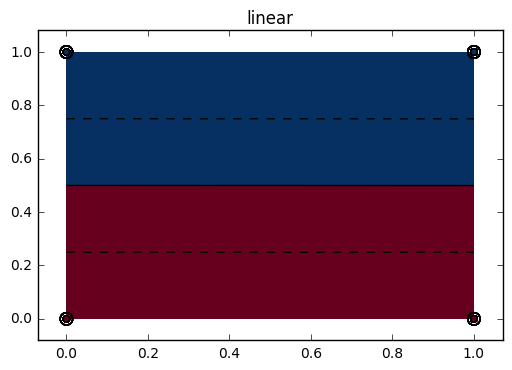

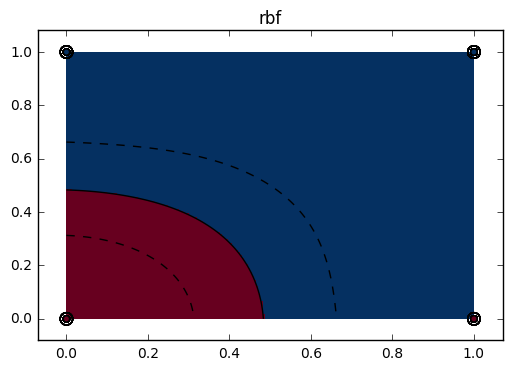

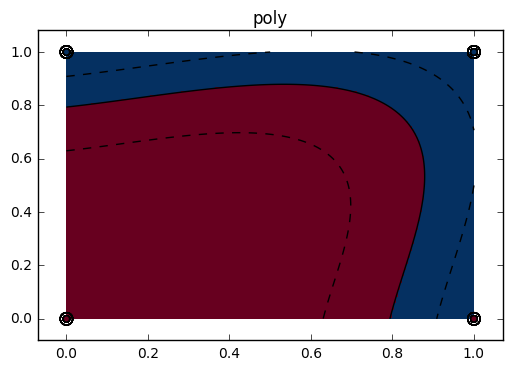

In [33]:
# set plotting parameters
plt.figure(figsize=(8,6))

# create a regression friendly data frame
y, x = dmatrices(formula_ml, data=df, return_type='matrix')

# select which features we would like to analyze
# try chaning the selection here for diffrent output.
# Choose : [2,3] - pretty sweet DBs [3,1] --standard DBs [7,3] -very cool DBs,
# [3,6] -- very long complex dbs, could take over an hour to calculate! 
feature_1 = 2
feature_2 = 3

X = np.asarray(x)
X = X[:,[feature_1, feature_2]]  


y = np.asarray(y)
# needs to be 1 dimenstional so we flatten. it comes out of dmatirces with a shape. 
y = y.flatten()      

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)

X = X[order]
y = y[order].astype(np.float)

# do a cross validation
nighty_precent_of_sample = int(.9 * n_sample)
X_train = X[:nighty_precent_of_sample]
y_train = y[:nighty_precent_of_sample]
X_test = X[nighty_precent_of_sample:]
y_test = y[nighty_precent_of_sample:]

# create a list of the types of kerneks we will use for your analysis
types_of_kernels = ['linear', 'rbf', 'poly']

# specify our color map for plotting the results
color_map = plt.cm.RdBu_r

# fit the model
for fig_num, kernel in enumerate(types_of_kernels):
    clf = svm.SVC(kernel=kernel, gamma=3)
    clf.fit(X_train, y_train)

    plt.figure(fig_num)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=color_map)

    # circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)
    
    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=color_map)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
               levels=[-.5, 0, .5])

    plt.title(kernel)
    plt.show()

In [95]:
# Here you can output which ever result you would like by changing the Kernel and clf.predict lines
# Change kernel here to poly, rbf or linear
# adjusting the gamma level also changes the degree to which the model is fitted
clf = svm.SVC(kernel='poly', gamma=4).fit(X_train, y_train)                                                            
y,x = dmatrices(formula_ml, data=test_data, return_type='dataframe')

# Change the interger values within x.ix[:,[6,3]].dropna() explore the relationships between other 
# features. the ints are column postions. ie. [6,3] 6th column and the third column are evaluated. 
res_svm = clf.predict(x.ix[:,[7,2]].dropna()) 

res_svm = DataFrame(res_svm,columns=['Survived'])
res_svm.Survived.value_counts()

0.0    223
1.0    109
Name: Survived, dtype: int64

RandomForest

In [96]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

# Create the random forest model and fit the model to our training data
y, x = dmatrices(formula_ml, data=df, return_type='dataframe')
# RandomForestClassifier expects a 1 demensional NumPy array, so we convert
y = np.asarray(y).ravel()
#instantiate and fit our model
results_rf = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

# Score the results
score = results_rf.score(x, y)
print "Mean accuracy of Random Forest Predictions on the data was: {0}".format(score)

Mean accuracy of Random Forest Predictions on the data was: 0.945224719101


In [106]:
results_rf.predict(x)

array([ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0